In [ ]:
Base.Threads.nthreads()

In [1]:
[0.31033984998979236 0.31033984998979214; 0.18966015001020783 0.1896601500102077]

2√ó2 Matrix{Float64}:
 0.31034  0.31034
 0.18966  0.18966

In [2]:
using Tullio
using KrylovKit: eigsolve
using LinearAlgebra

In [3]:
struct iMPS{T<:Number,F<:Number}
    Œì :: Array{T, 3}
    Œª :: Vector{F}
end
function iMPS(A::Array{T,3}) where {T<:Number}
    d = size(A, 1)
    @assert d == size(A, 2)
    return iMPS(A, ones(d)) 
end

bond_dims(œà::iMPS) = size(œà.Œì, 1)

function LinearAlgebra.dot(œà::iMPS, œï::iMPS)
    (; Œì, Œª) = œà
    Œìp, Œªp = œï.Œì, œï.Œª
    @assert size(Œì, 3) == size(Œìp, 3)
    
    matrixify(v) = reshape(v, size(Œì, 2), size(Œìp, 2))
    function fR(v)
        V = matrixify(v)
        @tullio tmp[ap,b,i] := conj(Œìp[ap,bp,i] * Œªp[bp]) * V[b,bp]
        (@tullio _[a,ap] := Œì[a,b,i] * Œª[b] * tmp[ap,b,i]) |> vec
    end
    valsR, vecsR, infoR = eigsolve(fR, vec(Matrix(1.0I,size(Œì, 2),size(Œìp,2))))
    Œ∑ = valsR[1]
end
overlap(œà::iMPS, œï::iMPS) = dot(œà, œï) / sqrt(dot(œà,œà) * dot(œï,œï))
LinearAlgebra.norm(œà::iMPS) = sqrt(dot(œà,œà))
LinearAlgebra.normalize!(œà::iMPS) = (œà.Œì ./= norm(œà); return œà)        

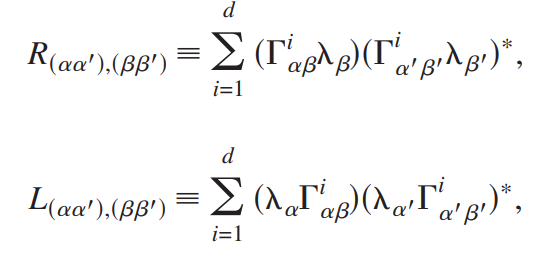

In [4]:
# @assert isdir("../TensorTrains/")

In [5]:
# ]dev ../TensorTrains/

In [6]:
using TensorTrains, TensorTrains.UniformTensorTrains
function TensorTrains.UniformTensorTrains.InfiniteUniformTensorTrain(œà::iMPS)
   (; Œì, Œª) = œà
   @tullio A[a,b,i] := Œì[a,b,i] * Œª[b]
    InfiniteUniformTensorTrain(A)
end

In [7]:
m = 20
Q = 4
A = Complex.(randn(m, m, Q))
œà = iMPS(A);

In [8]:
function canonicalize(œà::iMPS; svd_trunc=svd)
    (; Œì, Œª) = œà
    d = length(Œª)
    matrixify(v) = reshape(v, d, d)
    function fR(v)
        V = matrixify(v)
        @tullio tmp[ap,b,i] := conj(Œì[ap,bp,i] * Œª[bp]) * V[b,bp]
        (@tullio _[a,ap] := Œì[a,b,i] * Œª[b] * tmp[ap,b,i]) |> vec
    end
    function fL(v)
        V = matrixify(v)
        @tullio tmp[a,bp,i] := conj(Œì[ap,bp,i] * Œª[ap]) * V[a,ap]
        (@tullio _[b,bp] := Œì[a,b,i] * Œª[a] * tmp[a,bp,i]) |> vec
    end
    valsR, vecsR, infoR = eigsolve(fR, vec(Matrix(1.0I,d,d)))
    valsL, vecsL, infoL = eigsolve(fL, vec(Matrix(1.0I,d,d)))
#     @assert valsR[1] ‚âà valsL[1] "$(valsR[1]), $(valsL[1])"
    valsR[1] ‚âà valsL[1] || @warn "L and R do not have same leading eigenvalue: got $(valsR[1]), $(valsL[1])"
    VR = real(vecsR[1] ./ (vecsR[1][1] / abs(vecsR[1][1]))) |> matrixify |> Hermitian
    VL = real(vecsL[1] ./ (vecsL[1][1] / abs(vecsL[1][1]))) |> matrixify |> Hermitian
#     @show VL
#     FR = cholesky(VR, Val(false); check=false)
#     X = FR.L
#     FL = cholesky(VL, Val(false); check=false)
#     Y = FL.U
#     @assert VR[FR.p, FR.p] ‚âà X*X' "VR=$(VR[FR.p, FR.p]), $(X*X')"
#     @assert VL[FL.p, FL.p] ‚âà Y'Y "VL=$(VL[FL.p, FL.p]), $(Y'Y)"
    U, S, V = svd(VR)
    X = U * Diagonal(sqrt.(S))
    U, S, V = svd(VL)
    Y = Diagonal(sqrt.(S)) * V'
#     @assert VR ‚âà X*X' "VR=$(VR), $(X*X')"
#     @assert VL ‚âà Y'Y "VL=$(VL), $(Y'Y)"
    U, Œªp, V = svd_trunc(Y' * Diagonal(Œª) * X)
    L = V' * inv(X)
    R = inv(Y') * U
    @tullio tmp[a,c,i] := L[a,b] * Œì[b,c,i]
    @tullio Œìp[a,d,i] := tmp[a,c,i] * R[c,d]
    return iMPS(Œìp, Œªp)
end

canonicalize (generic function with 1 method)

In [9]:
œàp = canonicalize(œà; svd_trunc=TruncBond(15));

In [10]:
1 - overlap(œà, œàp)

0.054590307132273974 - 2.622212086419874e-15im

In [11]:
Q = 4
m = 30
ds = 1:(m√∑10):m+5
nsamples = 30;

In [12]:
using Unzip, Statistics, ProgressMeter

prog = Progress(length(ds))
errs_avg, errs_std, ovls_avg, ovls_std = map(ds) do d
    e,o = map(1:nsamples) do _
        A = complex.(rand(m, m, Q))     # matrix to be truncated. size is mxm, variable with 2 states
        œà = iMPS(A)
        p = InfiniteUniformTensorTrain(œà)
        œï = canonicalize(œà; svd_trunc=TruncBond(d))
        q = InfiniteUniformTensorTrain(œï)
        err = maximum(abs, only(marginals(p)) - only(marginals(q)))
        ovl = overlap(œà, œï)
        err, ovl
    end |> unzip
    next!(prog)
    mean(e), std(e)/sqrt(nsamples), mean(o), std(o)/sqrt(nsamples)
end |> unzip;

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:01:11


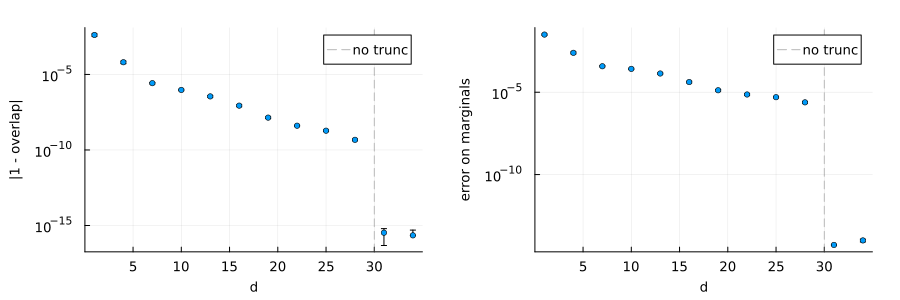

In [13]:
using Plots

pl1 = scatter(ds, abs.(1 .-ovls_avg), yerr=ovls_std, xlabel="d", ylabel="|1 - overlap|",
    label="", yaxis=:log10)
vline!(pl1, [m], ls=:dash, label="no trunc", c=:gray, la=0.5)
pl2 = scatter(ds, errs_avg, yerr=errs_std, xlabel="d", ylabel="error on marginals", label="", yaxis=:log10)
vline!(pl2, [m], ls=:dash, label="no trunc", c=:gray, la=0.5)
pl = plot(pl1, pl2, size=(900,300), margin=5Plots.mm, legend=:topright)

# BP

In [14]:
using Random, TensorCast

J = 0.1
Œ≤ = 1.0
h = 0.2
function f(J, h, Œ≤, x·µ¢·µó‚Å∫¬π,x‚Çô·µ¢·µó,x·µ¢·µó)
    @assert x·µ¢·µó‚Å∫¬π ‚àà 1:2
    @assert all(x ‚àà 1:2 for x in x‚Çô·µ¢·µó)
    potts2spin(x) = 3-2x
    h‚±º·µ¢ = Œ≤*J * sum(potts2spin, x‚Çô·µ¢·µó; init=0.0)
    E = - potts2spin(x·µ¢·µó‚Å∫¬π) * (h‚±º·µ¢ + Œ≤*h)
    return 1 / (1 + exp(2E))
end

f (generic function with 1 method)

In [15]:
function iterate_bp_vidal(f::Function, sz::Integer;
        maxiter=50, tol=1e-3,
        A0 = ones(1, 1, 2, 2) .+ 1e-5 .* rand.(),
        errs = fill(NaN, maxiter),
        ovls = fill(NaN, maxiter),
        Œµs = fill(NaN, maxiter),
        bds = fill(NaN, maxiter),
        beliefs = [complex.([NaN,NaN]) for _ in 1:maxiter])
    A = copy(A0)
    marg = fill(1/4, 4)
    @showprogress for it in 1:maxiter
        @tullio BB[m1,m2,n1,n2,x·µ¢·µó,x‚±º·µó,x·µ¢·µó‚Å∫¬π] := 
            f(J,h,Œ≤,x·µ¢·µó‚Å∫¬π,[x‚±º·µó,x‚Çñ·µó,x‚Çó·µó],x·µ¢·µó)*A[m1,n1,x‚Çñ·µó,x·µ¢·µó]*A[m2,n2,x‚Çó·µó,x·µ¢·µó] (x‚±º·µó in 1:2, x·µ¢·µó‚Å∫¬π in 1:2)
        @cast Q[(x·µ¢·µó, x‚±º·µó, m1, m2), (n1, n2, x·µ¢·µó‚Å∫¬π)] := BB[m1,m2,n1,n2,x·µ¢·µó,x‚±º·µó,x·µ¢·µó‚Å∫¬π]
        U, Œª, V = svd(Matrix(Q))
        @cast C[m,k,x·µ¢·µó,x‚±º·µó] := U[(x·µ¢·µó, x‚±º·µó, m), k] k:length(Œª), x·µ¢·µó:2, x‚±º·µó:2
        @cast Vt[m,n,x·µ¢·µó‚Å∫¬π] := V'[m, (n, x·µ¢·µó‚Å∫¬π)]  x·µ¢·µó‚Å∫¬π:2
        @tullio M[m,n,x·µ¢·µó,x‚±º·µó] := Œª[m] * Vt[m,l,x·µ¢·µó] * C[l,n,x·µ¢·µó,x‚±º·µó]
        
        Mresh = reshape(M, size(M,1), size(M,2), :) .|> complex
        œà = normalize!(iMPS(Mresh))
        p = InfiniteUniformTensorTrain(œà)
        œï = canonicalize(œà; svd_trunc=TruncBond(sz))
        bds[it] = bond_dims(œï)
        ovls[it] = overlap(œà,œï) |> abs
        q = InfiniteUniformTensorTrain(œï)
        marg_new = marginals(q) |> only
 
        Œµs[it] = maximum(abs, marg - only(marginals(p)))
        errs[it] = maximum(abs, only(marginals(p)) - only(marginals(q)))
        marg = marg_new
        A = reshape(q.tensor, size(q.tensor, 1), size(q.tensor, 2), 2, 2)
        b = belief(A)
        beliefs[it] .= b ./ sum(b)
        Œµs[it] < tol && return A, maxiter, Œµs, errs, ovls, bds, beliefs
    end
    return A, maxiter, Œµs, errs, ovls, bds, beliefs
end

# function belief(A, f::Function)
#     @tullio BB[m1,m2,m3,n1,n2,n3,x·µ¢·µó,x·µ¢·µó‚Å∫¬π] := 
#             f(J,h,Œ≤,x·µ¢·µó‚Å∫¬π,[x‚±º·µó,x‚Çñ·µó,x‚Çó·µó],x·µ¢·µó)*A[m1,n1,x‚Çñ·µó,x·µ¢·µó]*A[m2,n2,x‚Çó·µó,x·µ¢·µó]*A[m3,n3,x‚±º·µó,x·µ¢·µó] (x·µ¢·µó‚Å∫¬π in 1:2)
#     @cast M[(x·µ¢·µó,m1,m2,m3), (n1,n2,n3,x·µ¢·µó‚Å∫¬π)] := BB[m1,m2,m3,n1,n2,n3,x·µ¢·µó,x·µ¢·µó‚Å∫¬π]
#     U, Œª, V = svd(Matrix(M))
#     @cast C[m,k,x·µ¢·µó] := U[(x·µ¢·µó,m),k] k:length(Œª), x·µ¢·µó:2
#     @cast Vt[m,n,x·µ¢·µó‚Å∫¬π] := V'[m, (n, x·µ¢·µó‚Å∫¬π)]  x·µ¢·µó‚Å∫¬π:2
#     @tullio Anew[m,n,x·µ¢·µó] := Œª[m] * Vt[m,l,x·µ¢·µó] * C[l,n,x·µ¢·µó]
#     Anew
# end

function pair_belief(A)
    @cast _[(a·µó,b·µó),(a·µó‚Å∫¬π,b·µó‚Å∫¬π),x·µ¢·µó,x‚±º·µó] := A[a·µó,a·µó‚Å∫¬π,x·µ¢·µó, x‚±º·µó] * A[b·µó,b·µó‚Å∫¬π,x‚±º·µó,x·µ¢·µó]
end

belief(A) = sum(pair_belief(A), dims=(1,2,3)) |> vec

‚îå Warning: please replace index ranges like `i:3` with `i in 1:3` or `i ‚àà 1:3`
‚îÇ   call.string = "@cast C[m, k, x·µ¢·µó, x‚±º·µó] := U[(x·µ¢·µó, x‚±º·µó, m), k]  (k:length(Œª), x·µ¢·µó:2, x‚±º·µó:2)"
‚îî @ TensorCast ~/.julia/packages/TensorCast/mQB8h/src/macro.jl:1045
‚îå Warning: please replace index ranges like `i:3` with `i in 1:3` or `i ‚àà 1:3`
‚îÇ   call.string = "@cast C[m, k, x·µ¢·µó, x‚±º·µó] := U[(x·µ¢·µó, x‚±º·µó, m), k]  (k:length(Œª), x·µ¢·µó:2, x‚±º·µó:2)"
‚îî @ TensorCast ~/.julia/packages/TensorCast/mQB8h/src/macro.jl:1045
‚îå Warning: please replace index ranges like `i:3` with `i in 1:3` or `i ‚àà 1:3`
‚îÇ   call.string = "@cast C[m, k, x·µ¢·µó, x‚±º·µó] := U[(x·µ¢·µó, x‚±º·µó, m), k]  (k:length(Œª), x·µ¢·µó:2, x‚±º·µó:2)"
‚îî @ TensorCast ~/.julia/packages/TensorCast/mQB8h/src/macro.jl:1045


belief (generic function with 1 method)

In [16]:
d = 5
maxiter = 20
errs = fill(NaN, maxiter)
ovls = fill(NaN, maxiter)
Œµs = fill(NaN, maxiter)
bds = fill(NaN, maxiter)
beliefs = [complex.([NaN,NaN]) for _ in 1:maxiter]
A0 = reshape([0.31033984998979236 0.31033984998979214; 0.18966015001020783 0.1896601500102077], 1,1,2,2)
A, iters = iterate_bp_vidal(f, d; A0, tol=1e-6, maxiter, errs, ovls, Œµs, bds, beliefs);

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:17


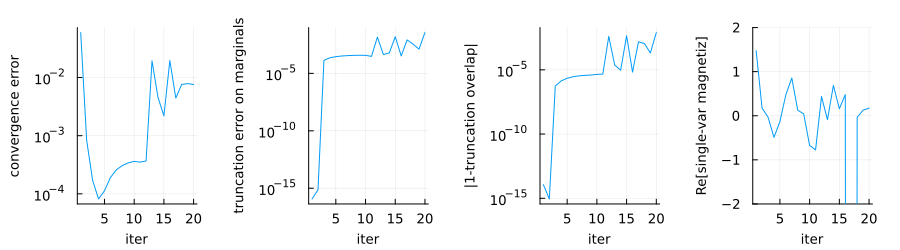

In [17]:
replace!(ovls, 1.0 => NaN);
p1 = plot(Œµs, xlabel="iter", ylabel="convergence error", yscale=:log10)
p2 = plot(errs, xlabel="iter", ylabel="truncation error on marginals", yscale=:log10)
p3 = plot(abs.(1 .- ovls), xlabel="iter", ylabel="|1-truncation overlap|", yscale=:log10)
# p4 = scatter(bds, ylabel="bond dim")
p4 = plot(reduce.(-, beliefs) .|> real, ylabel="Re[single-var magnetiz]", ylims=(-2,2))
pl = plot(p1, p2, p3, p4, layout=(1,4), size=(900,250), margin=5Plots.mm, labelfontsize=9,
    xlabel="iter", label="")

In [22]:
using ProfileVega, Profile
Profile.clear()
@profview A, iters = iterate_bp_vidal(f, d; A0, tol=1e-6, maxiter, errs, ovls, Œµs, bds, beliefs);

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:11


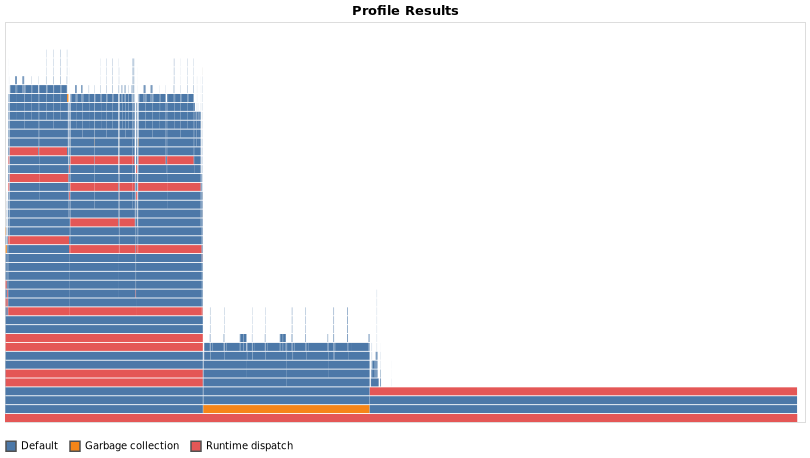

In [23]:
ProfileVega.view()

In [19]:
savefig(pl, "bp_vidal_ic_d$(d).pdf")

"/home/stecrotti/Desktop/phd/MPSExperiments.jl/bp_vidal_ic_d5.pdf"

In [17]:
d = 10
maxiter = 20
errs = fill(NaN, maxiter)
ovls = fill(NaN, maxiter)
Œµs = fill(NaN, maxiter)
bds = fill(NaN, maxiter)
A0 = reshape([0.31033984998979236 0.31033984998979214; 0.18966015001020783 0.1896601500102077], 1,1,2,2)
beliefs = [complex.([NaN,NaN]) for _ in 1:maxiter]
A, iters = iterate_bp_vidal(f, d; A0, tol=1e-6, maxiter, errs, ovls, Œµs, bds, beliefs);

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:08:29


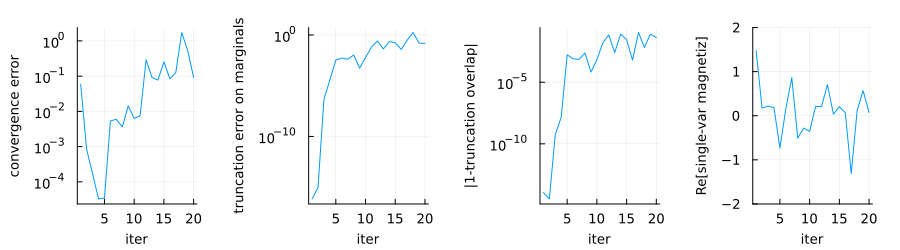

In [19]:
replace!(ovls, 1.0 => NaN);
p1 = plot(Œµs, xlabel="iter", ylabel="convergence error", yscale=:log10)
p2 = plot(errs, xlabel="iter", ylabel="truncation error on marginals", yscale=:log10)
p3 = plot(abs.(1 .- ovls), xlabel="iter", ylabel="|1-truncation overlap|", yscale=:log10)
# p4 = scatter(bds, ylabel="bond dim")
p4 = plot(reduce.(-, beliefs) .|> real, ylabel="Re[single-var magnetiz]", ylims=(-2,2))
pl = plot(p1, p2, p3, p4, layout=(1,4), size=(900,250), margin=5Plots.mm, labelfontsize=9,
    xlabel="iter", label="")

In [43]:
savefig(pl, "bp_vidal_ic_d$(d).pdf")

"/home/stecrotti/Desktop/phd/MPSExperiments.jl/bp_vidal_ic_d10.pdf"

In [ ]:
d = 25
maxiter = 5
errs = fill(NaN, maxiter)
ovls = fill(NaN, maxiter)
Œµs = fill(NaN, maxiter)
bds = fill(NaN, maxiter)
beliefs = [complex.([NaN,NaN]) for _ in 1:maxiter]
A, iters = iterate_bp_vidal(f, d; A0, tol=1e-6, maxiter, errs, ovls, Œµs, bds, beliefs);

Progress:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                |  ETA: 0:00:03‚îå Warning: L and R do not have same leading eigenvalue: got 1.1125237885760337 - 1.0391481334358149e-16im, 1.1359642162815105 + 1.2078146718908358e-16im
‚îî @ Main In[9]:18
Progress:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä        |  ETA: 0:13:08

In [ ]:
replace!(ovls, 1.0 => NaN);
p1 = plot(Œµs, xlabel="iter", ylabel="convergence error", yscale=:log10)
p2 = plot(errs, xlabel="iter", ylabel="truncation error on marginals", yscale=:log10)
p3 = plot(abs.(1 .- ovls), xlabel="iter", ylabel="|1-truncation overlap|", yscale=:log10)
# p4 = scatter(bds, ylabel="bond dim")
p4 = plot(reduce.(-, beliefs) .|> real, ylabel="Re[single-var magnetiz]", ylims=(-2,2))
pl = plot(p1, p2, p3, p4, layout=(1,4), size=(900,250), margin=5Plots.mm, labelfontsize=9,
    xlabel="iter", label="")

In [ ]:
savefig(pl, "bp_vidal_ic_d$(d).pdf")

Fare profiling!